<a href="https://colab.research.google.com/github/saeedghadiri/KaptchaSolver/blob/main/kaptcha_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and set random seeds

In [1]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
from PIL import ImageFilter
from PIL.ImageDraw import Draw
from PIL.ImageFont import truetype
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version:  2.7.0


# Set Parameters


## Data Parameters


In [2]:
IMG_FORMAT = 'jpg'
DATA_DIR = '/content/data'

# Desired image dimensions
img_width=200
img_height=50 

# text font size
font_size = 50
# text font color in rgb
font_color = '0,0,230'

# pool of character to sample from
char_pool = '0123456789'

# Maximum length of any captcha in the data
max_length=5

# sample_size
sample_size = 20000

# number of added space before captcha (for some captcha's we need space before chars)
add_space = 22

## Model Parameters

In [3]:
# test samples size
TEST_SPLIT = 0.2
# validation samples size
VAL_SPLIT = 0.1

# Batch size for training and validation
batch_size = 16

# Factor by which the image is going to be downsampled by the convolutional blocks
downsample_factor=4

# Create DataSet
we use kaptcha generator from https://github.com/saeedghadiri/KaptchaGenerator in order to create our dataset

In [4]:
!wget https://github.com/saeedghadiri/KaptchaGenerator/blob/master/kaptchagenerator.jar?raw=true
!mv kaptchagenerator.jar?raw=true kaptchagenerator.jar
!rm -r data

--2021-12-26 06:48:12--  https://github.com/saeedghadiri/KaptchaGenerator/blob/master/kaptchagenerator.jar?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/saeedghadiri/KaptchaGenerator/raw/master/kaptchagenerator.jar [following]
--2021-12-26 06:48:13--  https://github.com/saeedghadiri/KaptchaGenerator/raw/master/kaptchagenerator.jar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/saeedghadiri/KaptchaGenerator/master/kaptchagenerator.jar [following]
--2021-12-26 06:48:13--  https://raw.githubusercontent.com/saeedghadiri/KaptchaGenerator/master/kaptchagenerator.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuser

In [5]:
import subprocess
subprocess.call(['java', '-jar', 'kaptchagenerator.jar', 'data', str(img_width), str(img_height), str(font_size), font_color, char_pool, str(max_length), str(sample_size), str(add_space)])

0

# Check data


Get list of all the images


In [6]:
images = list(Path(DATA_DIR).glob("*." + IMG_FORMAT))
print("Number of images found: ", len(images))

Number of images found:  18099


Let's take a look at some samples.

Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


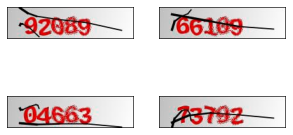

In [7]:
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

Now take a look at characters used in the captcha

In [8]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split("." + IMG_FORMAT)[0]
    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))
    
    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  10
Maximum length of any captcha:  5
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Total number of samples in the dataset:  18099


,img_path,label
0,/content/data/99164.jpg,99164
1,/content/data/34404.jpg,34404
2,/content/data/62135.jpg,62135
3,/content/data/69021.jpg,69021
4,/content/data/94619.jpg,94619


# Data Preparation

In [9]:

# Split the dataset into training and validation and test sets
train_dataset, test_data = train_test_split(dataset, test_size=TEST_SPLIT, random_state=seed)
training_data, validation_data = train_test_split(train_dataset, test_size=VAL_SPLIT, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))
print("Number of test samples: ", len(test_data))


# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}



# Sanity check for corrupted images
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True



# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """

    lower = np.array([150, 0, 0])
    upper = np.array([255, 150, 150])
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])

        img = cv2.inRange(img, lower, upper)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)



# Build training data
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)


# Build validation data
validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)


# Build validation data
test_data, test_labels = generate_arrays(df=test_data)
print("Number of test images: ", test_data.shape)
print("Number of test labels: ", test_labels.shape)

Number of training samples:  13031
Number of validation samples:  1448
Number of test samples:  3620
Number of training images:  (13031, 50, 200)
Number of training labels:  (13031,)
Number of validation images:  (1448, 50, 200)
Number of validation labels:  (1448,)
Number of test images:  (3620, 50, 200)
Number of test labels:  (3620,)


In [10]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [11]:

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

# Get a generator object for the validation data 
test_data_generator = DataGenerator(data=test_data,
                                     labels=test_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

# Define the Model

In [12]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss



def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model

model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_data (InputLayer)        [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['input_data[0][0]']             
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

# Fit the model to dataset

In [13]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=200,
                    callbacks=[es])

Epoch 1/200
815/815 [==============================] - 98s 97ms/step - loss: 9.8940 - val_loss: 3.8199
Epoch 2/200
815/815 [==============================] - 75s 92ms/step - loss: 1.6058 - val_loss: 0.2796
Epoch 3/200
815/815 [==============================] - 76s 93ms/step - loss: 0.3935 - val_loss: 0.0957
Epoch 4/200
815/815 [==============================] - 76s 93ms/step - loss: 0.2151 - val_loss: 0.0480
Epoch 5/200
815/815 [==============================] - 76s 93ms/step - loss: 0.1390 - val_loss: 0.0363
Epoch 6/200
815/815 [==============================] - 76s 93ms/step - loss: 0.1056 - val_loss: 0.0253
Epoch 7/200
815/815 [==============================] - 78s 95ms/step - loss: 0.0656 - val_loss: 0.0250
Epoch 8/200
815/815 [==============================] - 76s 93ms/step - loss: 0.0646 - val_loss: 0.0309
Epoch 9/200
815/815 [==============================] - 76s 93ms/step - loss: 0.0473 - val_loss: 0.0235
Epoch 10/200
815/815 [==============================] - 76s 93ms/step - l

# Save the model to use it later

In [14]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()
prediction_model.save('/content/model.pkl')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

INFO:tensorflow:Assets written to: /content/model.pkl/assets


INFO:tensorflow:Assets written to: /content/model.pkl/assets


In [15]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

Let's check results on some test samples

In [16]:
for p, (inp_value, _) in enumerate(test_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    print(type(X_data))
    preds = prediction_model.predict(X_data)
    print(preds.shape)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

<class 'numpy.ndarray'>
(16, 50, 11)
Ground truth: 98919 	 Predicted: 98919
Ground truth: 79895 	 Predicted: 79895
Ground truth: 75142 	 Predicted: 75142
Ground truth: 71017 	 Predicted: 71017
Ground truth: 95265 	 Predicted: 95265
Ground truth: 13022 	 Predicted: 13022
Ground truth: 53102 	 Predicted: 53102
Ground truth: 33115 	 Predicted: 33115
Ground truth: 57232 	 Predicted: 57232
Ground truth: 54450 	 Predicted: 54450
Ground truth: 66797 	 Predicted: 66797
Ground truth: 92795 	 Predicted: 92795
Ground truth: 87246 	 Predicted: 87246
Ground truth: 06301 	 Predicted: 06301
Ground truth: 80829 	 Predicted: 80829
Ground truth: 89350 	 Predicted: 89350


Find accuracy on test data

In [17]:
preds = prediction_model.predict(test_data_generator)
pred_texts = decode_batch_predictions(preds)
test_acc = np.sum(np.asarray(pred_texts) == test_data_generator.labels)/len(pred_texts)
print('test_acc: {}'.format(test_acc))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['input_label', 'input_length', 'label_length'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


test_acc: 0.9994475138121547


# Use the model

In [18]:
MODEL_DIR = '/content/drive/MyDrive/colab_data/model.pkl'

characters = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
labels_to_char = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
lower = np.array([150, 0, 0])
upper = np.array([255, 150, 150])

class CaptchaDeepSolver:
    def __init__(self, model_path, img_width=200, img_height=50):
        self.model = tf.keras.models.load_model(model_path, compile=False)

        self.img_width = img_width
        self.img_height = img_height

    def solve(self, image, resize=True):

        img = cv2.inRange(image, lower, upper)
        # img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if resize:
            img = cv2.resize(img, (self.img_width, self.img_height))

        img = (img / 255.).astype(np.float32)
        img = img.T

        img = np.expand_dims(img, axis=-1)
        img = np.expand_dims(img, axis=0)
        preds = self.model.predict(img)
        pred_texts = self.decode_batch_predictions(preds)
        return pred_texts

    # A utility to decode the output of the network
    @staticmethod
    def decode_batch_predictions(prediction):
        pred = prediction[:, :-2]
        input_len = np.ones(pred.shape[0]) * pred.shape[1]

        # Use greedy search. For complex tasks, you can use beam search
        results = keras.backend.ctc_decode(pred,
                                           input_length=input_len,
                                           greedy=True)[0][0]

        # Iterate over the results and get back the text
        output_text = []
        for res in results.numpy():
            outstr = ''
            for c in res:
                if c < len(characters) and c >= 0:
                    outstr += labels_to_char[c]
            output_text.append(outstr)

        # return final text results
        return output_text

In [19]:
# Load the model
model = CaptchaDeepSolver('/content/model.pkl')

for index, row in dataset[:100].iterrows():
  # Load the image
  img = cv2.imread(row['img_path'])

  # Predict the text
  pred_texts = model.solve(img)

  # Print the results
  print('true: {} predicted: {}'.format(row['label'], pred_texts))

true: 99164 predicted: ['99164']
true: 34404 predicted: ['34404']
true: 62135 predicted: ['62135']
true: 69021 predicted: ['69021']
true: 94619 predicted: ['94619']
true: 50217 predicted: ['50217']
true: 25750 predicted: ['25750']
true: 27488 predicted: ['27488']
true: 20272 predicted: ['20272']
true: 73751 predicted: ['73751']
true: 71752 predicted: ['71752']
true: 13299 predicted: ['13299']
true: 25717 predicted: ['25717']
true: 98472 predicted: ['98472']
true: 42006 predicted: ['42006']
true: 04765 predicted: ['04765']
true: 05012 predicted: ['05012']
true: 60374 predicted: ['60374']
true: 95388 predicted: ['95388']
true: 69789 predicted: ['69789']
true: 30734 predicted: ['30734']
true: 10974 predicted: ['10974']
true: 90016 predicted: ['90016']
true: 98972 predicted: ['98972']
true: 07057 predicted: ['07057']
true: 45881 predicted: ['45881']
true: 98936 predicted: ['98936']
true: 99443 predicted: ['99443']
true: 68817 predicted: ['68817']
true: 72262 predicted: ['72262']
true: 9309